## Violations Search Tau

> Written by Jess Breda September 2023

For this notebook, I am working based on the to-dos from 2023-08-29 meeting and previous notebook `2023_08_violations_feature_analysis`/

The goals for this NB are

1. Update & test code to only apply exp filter to a session at a time

2. Update code to normalize all together before train test split. This might mean changing the order in generate_design_matrix. 
    * Or just a function that takes a list of dfs and finds the max value and normalize them by it?
    * Or just pass in the generated design matrix into train test split

3. Iterate over a finer grid of taus and sigmas

sigmas = 0.01, 0.1, 0.2, 0.5, 1, 1.5, 2, 2.5, 3, 5

taus = 1, 2, 3, 5, 10, 12, 15, 17, 20, 25, 30

### Apply exp filter on session by session basis

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


class ExpFilter:
    def __init__(self, tau, column="violation", len_factor=5, verbose=True):
        self.tau = tau
        self.column = column
        self.len_factor = len_factor
        self.verbose = verbose

    def create_kernel(self):
        return np.array(
            [np.exp(-i / self.tau) for i in range(self.len_factor * self.tau)]
        )

    def apply_filter_to_session(self, session_df):
        kernel = self.create_kernel()

        # Convolve the kernel with selected column
        convolution_result = np.convolve(session_df[self.column], kernel, mode="full")[
            : len(session_df)
        ]

        session_df[f"{self.column}_exp_{self.tau}"] = convolution_result

        return session_df

    def apply_filter_to_dataframe(self, source_df, output_df=None):
        if self.tau is None:
            return

        if output_df is None:
            output_df = source_df

        for session_id, session_data in source_df.groupby("session"):
            filtered_session = self.apply_filter_to_session(session_data.copy())
            output_df.loc[
                output_df["session"] == session_id, f"{self.column}_exp_{self.tau}"
            ] = filtered_session[f"{self.column}_exp_{self.tau}"]

            if self.verbose:
                print(
                    f"Exp filter added for session {session_id} | Column: {self.column}, Tau: {self.tau}"
                )


# Example usage
df = pd.DataFrame(
    {
        "session": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3],
        "violation": np.random.randint(0, 2, 22),
    }
)

filter_obj = ExpFilter(tau=3, column="violation")
filter_obj.apply_filter_to_dataframe(df)

Exp filter added for session 1 | Column: violation, Tau: 3
Exp filter added for session 2 | Column: violation, Tau: 3
Exp filter added for session 3 | Column: violation, Tau: 3


Text(0.5, 0, 'Trial')

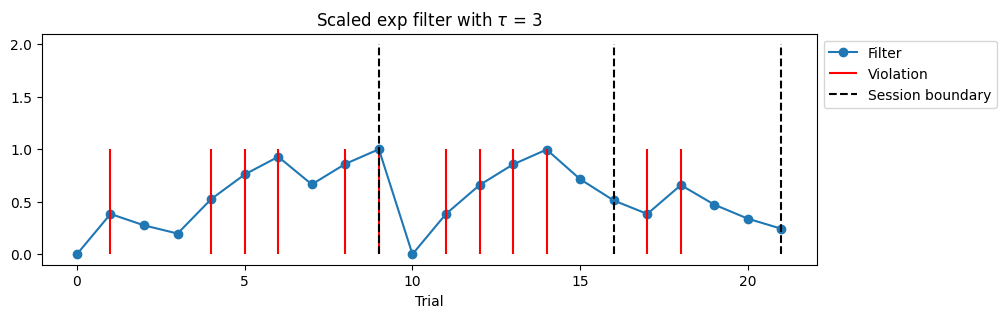

In [32]:
fig, ax = plt.subplots(figsize=(10, 3))
plt.plot(
    df["violation_exp_3"] / df["violation_exp_3"].max(), label="Filter", marker="o"
)

# Iterate through the prev_violation column and plot vertical lines when the value is 1
for idx, value in df["violation"].items():
    if value == 1:
        plt.vlines(x=idx, ymin=0, ymax=1, color="r", label="Violation")

# Plot black vertical lines for session boundaries
last_idx_of_each_session = df["session"].duplicated(keep="last")
for idx, is_duplicated in enumerate(last_idx_of_each_session):
    if not is_duplicated:
        plt.vlines(
            x=idx,
            ymin=0,
            ymax=2,
            color="k",
            linestyles="dashed",
            label="Session boundary",
        )


# Add legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1, 1), loc=2)

plt.title(f"Scaled exp filter with $\\tau$ = {3}")
plt.xlabel("Trial")